In [1]:
import itertools
import pandas as pd
import numpy as np
np.random.seed(42)
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib as mpl

from utils import load_everything

dark_mode = True
if dark_mode:
    COLOR = '#bbccd5'
    BG = '#23272a'
    # print(mpl.rcParams.keys()) # see all params
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR
    mpl.rcParams['figure.facecolor'] = BG
    mpl.rcParams['figure.figsize'] = [16, 9]


## Load the Dataset

In [2]:
# the dataset contains all of the metadata test and train sets are self explanatory 
# no shuffling is required this is all done in the loader. indexes match between the dataset and x_train etc
# to index for the test set do dataset[len(x_train):]
dataset, (x_train, x_test, y_train, y_test) = load_everything(os.path.join('..', 'datasets'))

## GPU Setup

In [3]:
# Tensorflow Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing


# Setup the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.0
Num GPUs Available:  1


## CNN

There are 6708 images in the dataset
There are 1000 fire images
There are 5708 non-fire images
Index(['img_name', 'img_source', 'fire', 'pos_y', 'pos_x', 'wind_direction',
       'wind_strength'],
      dtype='object')


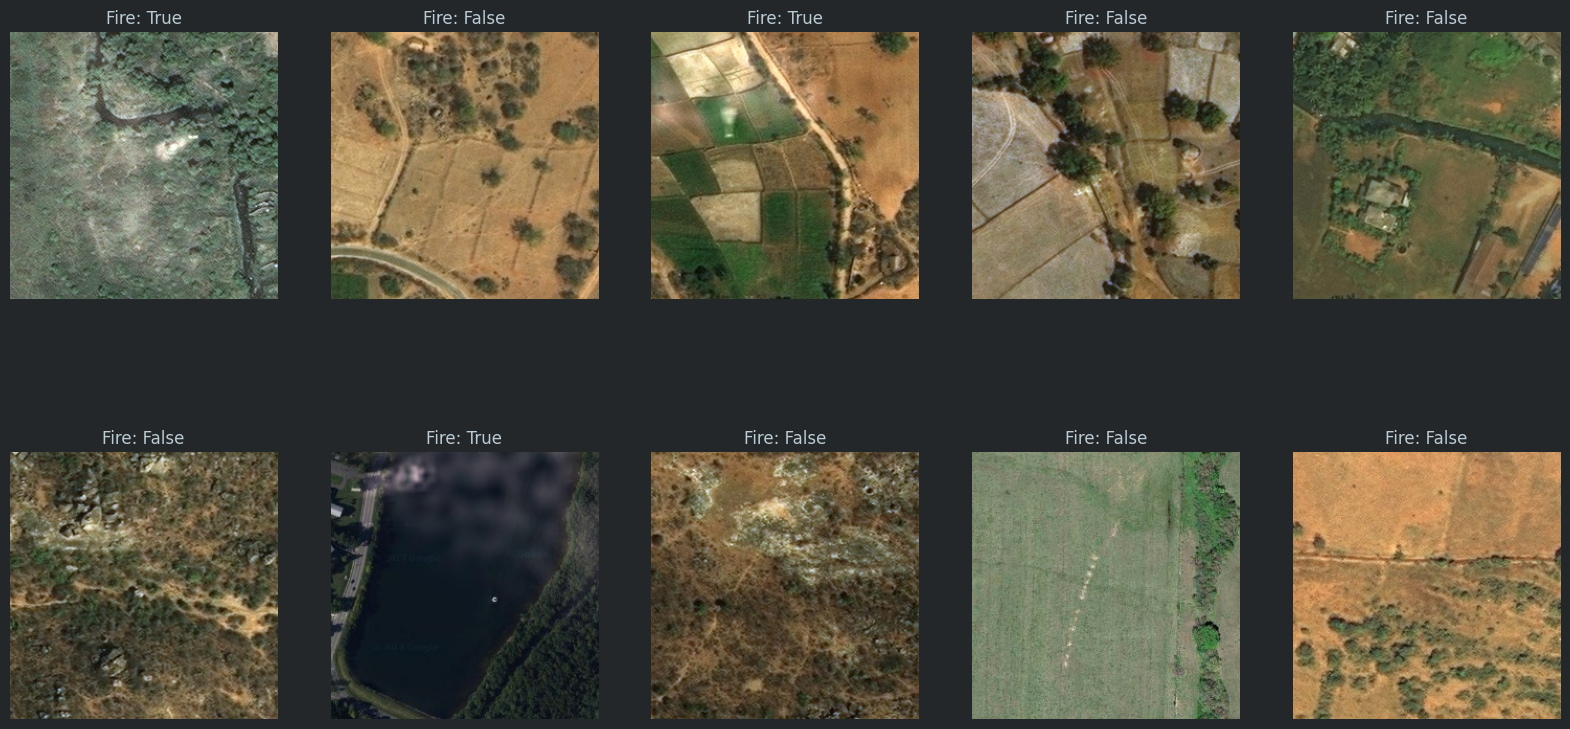

In [4]:
print(f'There are {len(dataset)} images in the dataset')
print(f'There are {len(dataset[dataset["fire"] == 1])} fire images')
print(f'There are {len(dataset[dataset["fire"] == 0])} non-fire images')

#All the columns in the dataset
print(dataset.columns)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_train[i])
    ax[i // 5, i % 5].set_title(f'Fire: {y_train[i]}')
    ax[i // 5, i % 5].axis('off')


In [5]:
# Load the MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

x_train shape: (5031, 224, 224, 3)
x_test shape: (1677, 224, 224, 3)


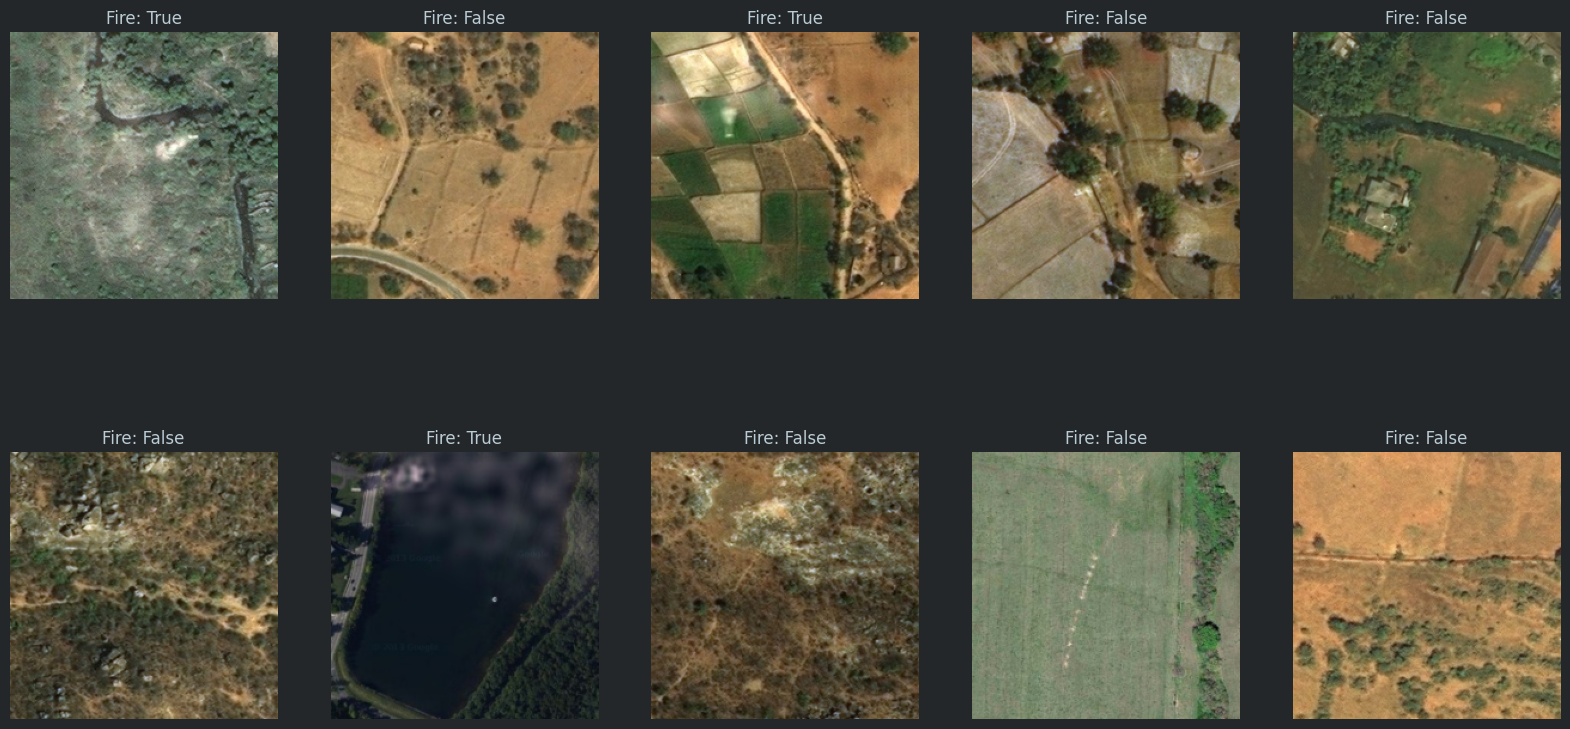

In [6]:
# Change the shape of the images to 224, 224, 3 for MobileNetV2
x_train = np.array([cv2.resize(img, (224, 224)) for img in x_train])
x_test = np.array([cv2.resize(img, (224, 224)) for img in x_test])
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

# Display some random resized images
# Convert the images to a displayable format for matplotlib
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_train[i])
    ax[i // 5, i % 5].set_title(f'Fire: {y_train[i]}')
    ax[i // 5, i % 5].axis('off')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

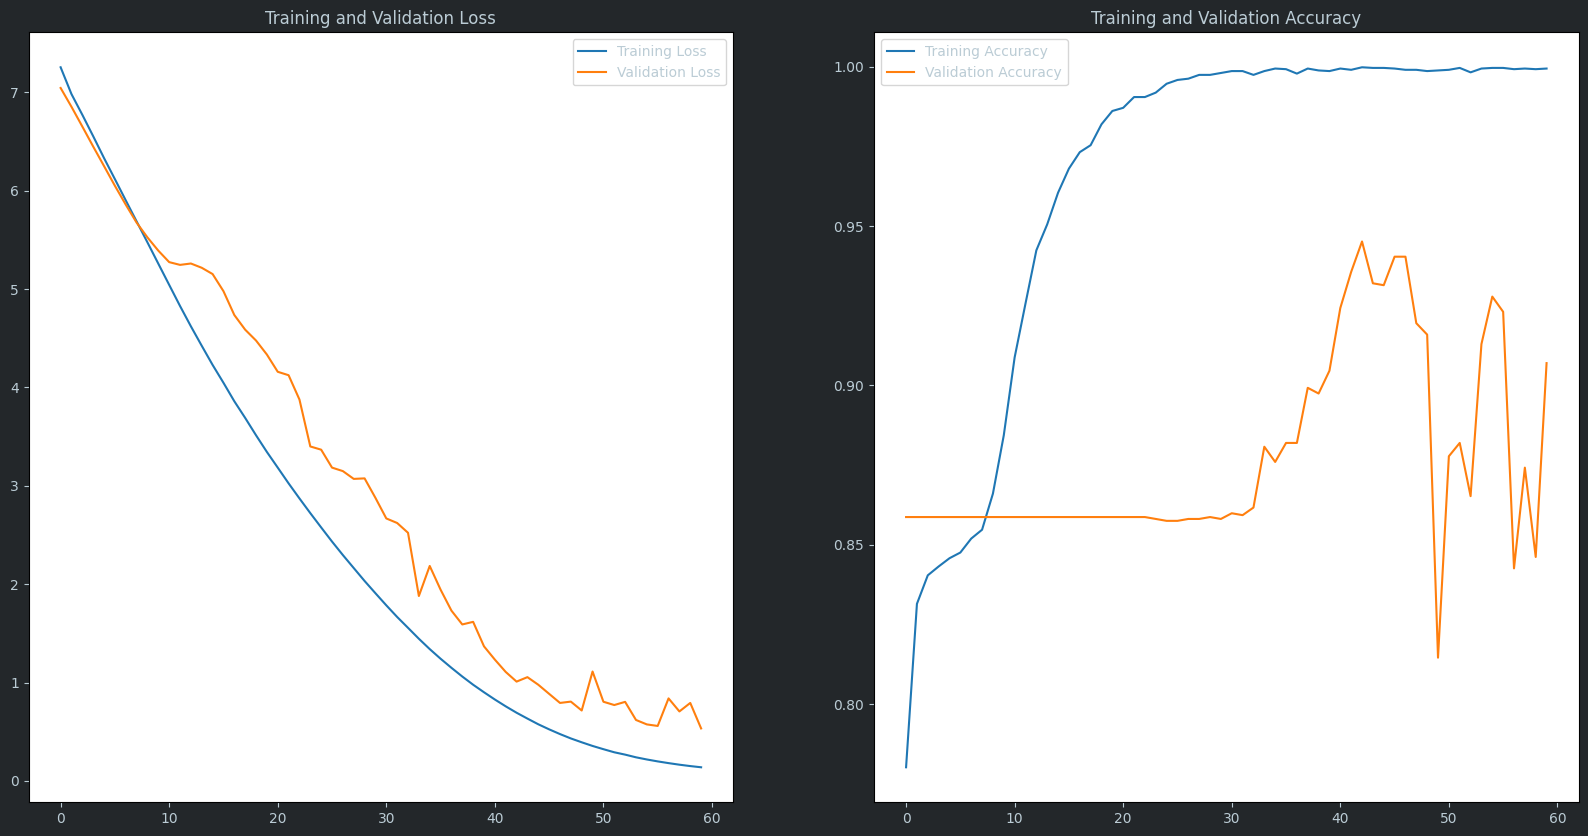

In [7]:
# Preprocess the images
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Add a global spatial average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x) # Dropout helps prevent overfitting

# Implement weight decay
x = layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)


# Add a final sigmoid layer for classification
predictions = layers.Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Check the final model architecture
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=60, validation_data=(x_test, y_test))

# Plot the training and validation loss + accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()



Evaluate on test data
1/1 [==============================] - 1s 888ms/step
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]]
[False False False False False]
53/53 [==============================] - 1s 15ms/step
[[1326  114]
 [  42  195]]
              precision    recall  f1-score   support

       False       0.97      0.92      0.94      1440
        True       0.63      0.82      0.71       237

    accuracy                           0.91      1677
   macro avg       0.80      0.87      0.83      1677
weighted avg       0.92      0.91      0.91      1677



<Axes: >

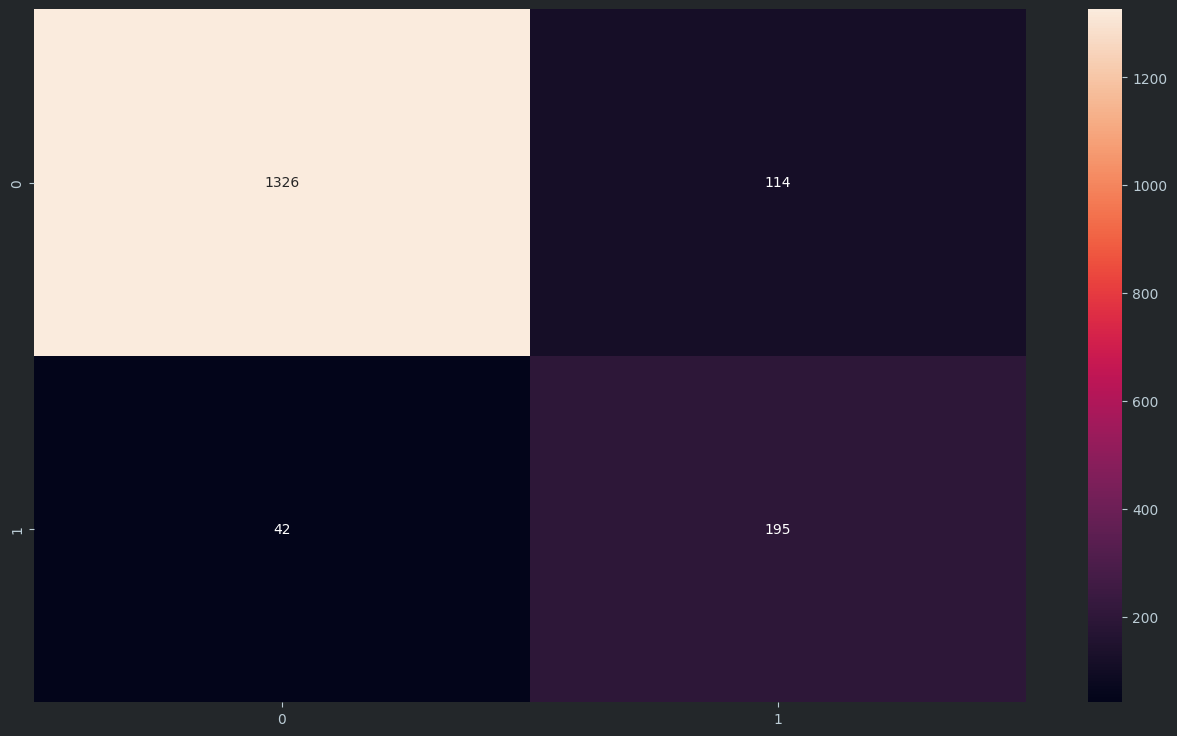

In [8]:
# Evaluate the model on the test data using `evaluate`
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
print("Evaluate on test data")
# results = model.evaluate(x_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

# Predict on the first 5 test images.
predictions = model.predict(x_test[:5])

# Print our model's predictions.
print(np.round(predictions))

# Check our predictions against the ground truths.
print(y_test[:5])

# Show the confusion matrix and other metrics

y_pred = np.round(model.predict(x_test))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

sns.heatmap(cm, annot=True, fmt='d')
